# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
TODO

### Baseline Model
TODO

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
from sklearn import metrics

In [174]:
eighteen = pd.read_csv("2018.csv")
nineteen = pd.read_csv("2019.csv")
result = pd.concat([eighteen, nineteen])
result = result.reset_index(drop=True)

Prediction: We will try to predict the reach, or the number of views, of an ad. This is a regression problem. 

### Baseline Model

In [175]:
# changing all dates to datetime objects
result['StartDate'] = result['StartDate'].str[:-1]
result['EndDate'] = result['EndDate'].str[:-1]
result['StartDate'] = pd.to_datetime(result['StartDate'])
result['EndDate'] = pd.to_datetime(result['EndDate'], errors='coerce')


In [176]:
# EndDate                         fill with "Present" or current time
result['EndDate'] = result['EndDate'].fillna(datetime.utcnow())
# Gender                          fill with "All"
result['Gender'] = result['Gender'].fillna("All")
# display(result[['StartDate', 'EndDate']])
result['Duration'] = abs(result['EndDate']- result['StartDate'])
duration = abs(result['EndDate']- result['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

result["MediaType"] = result['CreativeUrl'].str.extract('.+mediaType=([A-z0-9]+)', expand=True)
result["MediaType"] = result["MediaType"].str.lower()
result["MediaType"] = result["MediaType"].str.replace("jpeg", "jpg")
# result["MediaType"].value_counts()
result = result.drop("CreativeUrl",axis=1)
result['Duration']
# Quantitative: Impressions, Spend, Duration
# Nominal: CountryCode, Gender, MediaType

0        459
1        335
2        683
3        335
4        769
        ... 
2184    2214
2185    2315
2186     263
2187    2317
2188    6608
Name: Duration, Length: 2189, dtype: int64

In [177]:
result = result[['Impressions', 'Duration', 'Spend','Gender', 'CountryCode', 'MediaType']]

In [178]:
X = result.drop(['Impressions'], axis=1)
y = result.Impressions

In [179]:
# TODO
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl = Pipeline([('feats', ct), ('reg', LinearRegression())])

# X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
# pl.fit(X_tr, y_tr)
# rsquared = pl.score(X_ts, y_ts)
# print("r-squared: " + str(rsquared))
# preds = pl.predict(X_ts)
# rmse = np.sqrt(np.mean(preds - y_ts)**2)
# print("rmse: " + str(rmse))
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    rsquared = pl.score(X_ts, y_ts)
    out.append(rsquared)
np.mean(out)

-2229915397584.6255

### Final Model

In [180]:
from sklearn.ensemble import RandomForestRegressor

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

In [181]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))
# preds

r-squared: 0.6922147732083729
rmse: 13028.46239659367


/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [182]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    rsquared = pl.score(X_ts, y_ts)
    out.append(rsquared)
# out

### Fairness Evaluation

In [183]:
# X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
# pl2.fit(X_tr, y_tr)
# pl2.score(X_ts,y_ts)
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    rsquared = pl2.score(X_ts, y_ts)
    out.append(rsquared)
np.mean(out)

0.6513970256357092

### Permutation Testing

In [184]:
#3130994.5 Impressions threshold

In [185]:
results = X_ts
results["prediction"] = preds
results['prediction'] = (results.prediction <= 3130994.5).replace({True:'Small', False:'Large'})
                        
results["Impressions"] = y_ts
results['Impressions'] = (results.Impressions <= 3130994.5).replace({True:'Small', False:'Large'})

results



/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Duration,Spend,Gender,CountryCode,MediaType,prediction,Impressions
879,527,9,All,united states,png,Small,Small
97,267,11977,All,united states,mp4,Small,Large
356,1135,26,All,united kingdom,mp4,Small,Small
1113,11,5,All,united states,png,Small,Small
868,567,6,All,united states,mp4,Small,Small
...,...,...,...,...,...,...,...
552,976,3621,All,united states,mp4,Small,Small
1626,580,161,All,norway,mp4,Small,Small
570,10246,228,All,united states,mp4,Small,Small
1816,3710,3351,MALE,united states,mp4,Small,Small


In [186]:
#12 hours, less than is considered short, more than is consiered long
results['duration_cat'] = (results.Duration <= 720).replace({True:'short', False:'long'})
# results["Duration"].hist(bins=20)


/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
obs = results.groupby('duration_cat').apply(lambda x: metrics.accuracy_score(x.Impressions, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        results[['duration_cat', 'prediction', 'Impressions']]
        .assign(duration_cat=results.duration_cat.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('duration_cat')
        .apply(lambda x: metrics.accuracy_score(x.Impressions, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)


0.67


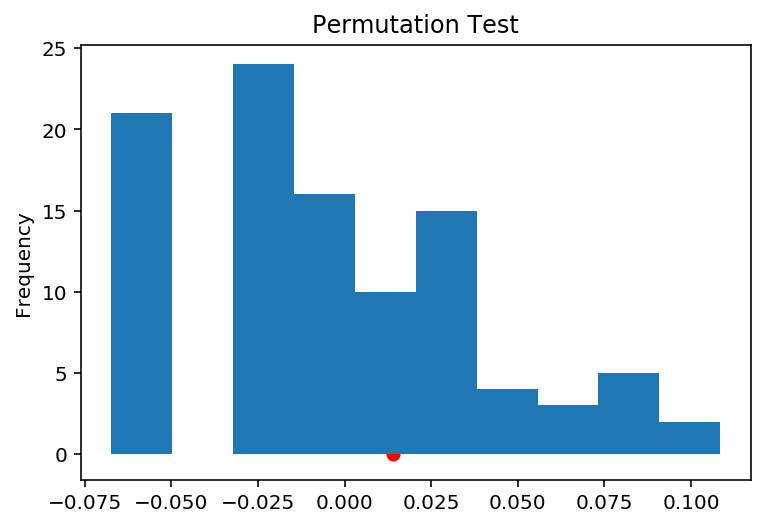

In [188]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test')
plt.scatter(obs, 0, c='r');
